## Ligand based pharmacophores by clique detection
Clique detection algorithm by [Podolyan and Karypis, 2009](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2631088/)

In [2]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import ChemicalFeatures
from rdkit import RDConfig
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.ipython_useSVG=True

import numpy as np
import numpy.linalg as LA
import networkx as nx
import networkx.algorithms.isomorphism as iso
import os
import pickle
import matplotlib.pyplot as plt
from itertools import combinations

## Creating the conformers graphs

In [3]:
def bin_distance(distance, bin_size=1):
    """Group distances into bins defined by bin_size"""
    bins = np.arange(21, step=bin_size)
    last_bin = bins[distance > bins][-1]
    
    if distance == last_bin or distance < last_bin + bin_size/2:
        binned_distance = last_bin
    elif distance >= last_bin + bin_size/2:
        binned_distance = last_bin + bin_size

    return binned_distance

def distance_between_pharmacophore_points(p1_coords, p2_coords):
    """Computes the distance between pharmacophore points or edges in a conformer graph"""
    
    vector = p2_coords - p1_coords #vector between the two points
    distance = LA.norm(vector)
    
    return distance

def feature_centroid(molecule, conformer_idx, atom_indxs):
    """Get the 3D coordinates of the centroid of a feature that encompasses
       more than one atom. This could be aromatic, hydrophobic, negative and positive features
    """
    
    n_atoms = len(atom_indxs)
    coords = np.zeros((n_atoms, 3))
    for j, idx in enumerate(atom_indxs):
            position = molecule.GetConformer(conformer_idx).GetAtomPosition(idx)
            coords[j, 0] = position.x
            coords[j, 1] = position.y
            coords[j, 2] = position.z
    
    centroid = coords.mean(axis=0)
   
    return centroid

def get_rdkit_features(molecule, cf_graph, conformer_idx, accepted_feats=[]):
    """Load default rdkit features and add them to the graph"""
    
    fdefName = os.path.join(RDConfig.RDDataDir,'BaseFeatures.fdef')
    factory = ChemicalFeatures.BuildFeatureFactory(fdefName)
    feats = factory.GetFeaturesForMol(molecule)
    
    if not accepted_feats:
        accepted_feats = ['Acceptor', 'Aromatic', 'Donor', 'Hydrophobe']
    
    i = 0
    for feature in feats:
        feat_name = feature.GetFamily()  
        if feat_name not in accepted_feats:
            continue

        atom_idxs = feature.GetAtomIds()

        if len(atom_idxs) > 1: # it's an aromatic feature!
            coords = feature_centroid(molecule, conformer_idx, atom_idxs)
        else:
            position = molecule.GetConformer(conformer_idx).GetAtomPosition(atom_idxs[0])
            coords = np.zeros((3,))
            coords[0] = position.x
            coords[1] = position.y
            coords[2] = position.z
        
        cf_graph.add_node(i, feat_type=feat_name, coordinates=coords)
        i += 1

def get_smarts_features(molecule, cf_graph, conformer_idx, accepted_feats=[]):
    """Load features from a file. Custom features taken from 
        Kutlushina, Alina, Aigul Khakimova, Timur Madzhidov, and Pavel Polishchuk. 
        "Ligand-based pharmacophore modeling using novel 3D pharmacophore signatures." 
        Molecules 23, no. 12 (2018): 3094
    """
    with open('./data/smarts_feats', 'rb') as f:
        feats_dict = pickle.load(f)
    
    i = 0
    for feat, feat_type in feats_dict.items():
        if accepted_feats and feat_type not in accepted_feats:
            continue
        pattern = Chem.MolFromSmarts(feat)  
        atom_idxs = molecule.GetSubstructMatch(pattern)
        if len(atom_idxs) == 0:
            continue
        
        if len(atom_idxs) == 1: # Donor or acceptor feature
            position = molecule.GetConformer(conformer_idx).GetAtomPosition(atom_idxs[0])
            coords = np.zeros((3,))
            coords[0] = position.x
            coords[1] = position.y
            coords[2] = position.z
        else: # Aromatic, hydrophobic, positive or negative feature
            coords = feature_centroid(molecule, conformer_idx, atom_idxs)
        
        cf_graph.add_node(i, feat_type=feat_type, coordinates=coords)
        i += 1

        
def conformer_graph(molecule, conformer_idx, features='rdkit', accepted_feats=[], bin_size=1, min_distance=2, max_distance=13):
    
    cf_graph = nx.Graph()
    
    # Create the graph nodes or pharmacophore points
    if features == 'rdkit':
        get_rdkit_features(molecule, cf_graph, conformer_idx)
    elif features == 'smarts':
        get_smarts_features(molecule, cf_graph, conformer_idx, accepted_feats)
    
    # Add edges 
    points = list(cf_graph.nodes())
    points_to_delete = set()
    for pi, pj in combinations(points, 2): #combinations between all pharmacophore points
        pi_coords = cf_graph.nodes[pi]['coordinates']
        pj_coords = cf_graph.nodes[pj]['coordinates']
        distance = distance_between_pharmacophore_points(pi_coords, pj_coords)
        if distance < min_distance:
            # Should points that are two close be assigned two labels ?
            # Extract label from pj and add it to the list
            new_label = cf_graph.nodes[pj]['feat_type'] 
            cf_graph.nodes[pi]['feat_type_2'] = new_label
            points_to_delete.add(pj)
        elif distance > max_distance:
            # What to do with this points?
            continue
        else:
            binned_distance = bin_distance(distance, bin_size=bin_size)
            cf_graph.add_edge(pi, pj, distance=binned_distance)
    
    for point in points_to_delete:
        cf_graph.remove_node(point)
    
    return cf_graph

def generate_conformers(molecule, n_conformers):
    """Generate n conformers for a molecule"""
    molecule = Chem.AddHs(molecule) # Add hydrogens to generate realistic geometries
    cids = AllChem.EmbedMultipleConfs(molecule, numConfs=n_conformers)
    AllChem.AlignMolConformers(molecule)
    
    return molecule


### Load molecules from a smi file

5 molecules


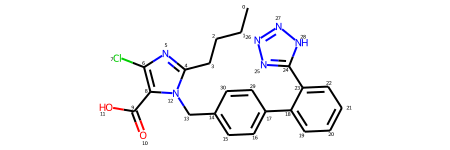

In [4]:
# Load inhibitors from smi file 
molecules = Chem.SmilesMolSupplier('./data/molecules.smi',delimiter='\t',titleLine=False)
print(f"{len(molecules)} molecules")
# Visualize first molecule
molecules[0]

In [5]:
# Generate graphs for all confomers
D = [] # List containing a list of graphs for each molecule conformers
n_conformers = 30
for mol in molecules:
    mol = generate_conformers(mol, n_conformers)
    graphs = []
    for cidx in range(n_conformers):
        cf_graph = conformer_graph(molecule=mol, conformer_idx=cidx, features='rdkit', accepted_feats=['Acceptor', 'Aromatic'])
        graphs.append(cf_graph)
    D.append(graphs)

In [6]:
len(D)

5

In [7]:
max([g.number_of_nodes() for g in D[3]])

7

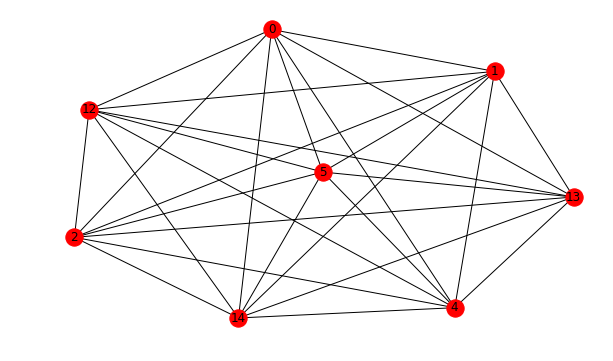

In [8]:
# Plot a sample graph
fig, ax = plt.subplots(figsize=(10,6))
nx.draw(D[0][2], with_labels=True, ax=ax)
plt.show()

## Clique detection algorithm

In [9]:
def find_all_cliques(D, clique_size=None):
    """
    Finds all cliques in each of the conformer graphs.
    Returns a dictionary with the keys as the conformer id and
    the values as a list of all n-cliques for each conformer
    An example id is 012 where the first number represents the molecule index,
    the second number the conformer index and the third number the clique index
    """
        
    cliques_dict = {}
    for i, molecule in enumerate(D):
        for j, conformer in enumerate(molecule):
            if clique_size:
                size = clique_size
                cliques = [c for c in list(nx.enumerate_all_cliques(conformer)) if len(c) == size]
            else:
                cliques = [c for c in list(nx.enumerate_all_cliques(conformer)) if len(c) > 1]
            for k, clique in enumerate(cliques):
                clique_id = str(i) + str(j) + str(k)
                clique_graph = conformer.subgraph(clique)
                cliques_dict[clique_id] = clique_graph

    return cliques_dict

def find_clique_support(cliques_dict, sigma):
    """
    Find the support of each clique. The support of a given clique is the number of 
    molecules that contain at least one conformer that contains that clique
    """
    # Functions to check graph isomorphism
    nm = lambda x, y: x['feat_type'] == y['feat_type'] # Match nodes feature type
    em = iso.categorical_edge_match('distance', 'distance') # Match edges distances
    
    support = {} # Dictionary for the frequency of each clique
    min_support = len(D) * sigma
    
    i = 0
    mol_id = ''
    for c1_id, c1 in cliques_dict.items():
        support[c1_id] = 0
        
        for c2_id, c2 in cliques_dict.items():
            
            if c2_id[0] == i or c2_id[0] == mol_id:
                continue # Skip subgraphs of the same molecule or that have been found to be supported by a molecule
            
            if c1.number_of_nodes() != c2.number_of_nodes():
                continue # if the number of nodes of clique-1 is different from clique-2 it cannot be isomorphic
            
            if nx.is_isomorphic(c1, c2, node_match=nm, edge_match=em):
                mol_id = c2_id[0] # Track id of the molecule that supports a given clique
                support[c1_id] += 1
        
        i += 1
        mol_id = ''
    
    support = {k:v for k, v in support.items() if v >= min_support}
                
    return support

In [10]:
def prune_cliques(cliques, s):
    """
    Remove cliques that do not have the minimun support. Then, remove
    cliques that are subgraphs of larger cliques.
    """
    
    pruned_cliques = {clique_id: subgraph for clique_id,subgraph in cliques.items() if clique_id in s.keys()}
    n_molecules = 5
    n_conformers = 10
    
    for i in range(n_molecules):
        for j in range(n_conformers):
            conformer_id = str(i) + str(j)
            conformer_cliques = {k:v for k, v in pruned_cliques.items() if k.startswith(conformer_id)}
            
            if len(conformer_cliques) == 0:
                continue
                
            max_clique_size = max(c.number_of_nodes() for c in conformer_cliques.values())
            for c in conformer_cliques:
                if not pruned_cliques[c].number_of_nodes() == max_clique_size:
                    pruned_cliques.pop(c)
                
            
    return pruned_cliques


def common_pharmacophores(D, sigma):
    
    cliques = find_all_cliques(D)
    support = find_clique_support(cliques, sigma=sigma)
    pruned_cliques = prune_cliques(cliques, support)
    
    common_pharmacophores = list(pruned_cliques.values())
    
    return common_pharmacophores

In [11]:
cliques = find_all_cliques(D, clique_size=5)
print("{} cliques".format(len(cliques)))

4900 cliques


In [ ]:
support = find_clique_support(cliques, 1)
print("{} cliques supported by the {} molecules".format(len(support), len(D)))

In [ ]:
p_cliques = prune_cliques(cliques, support)
print("{} cliques after pruning".format(len(p_cliques)))

In [ ]:
# Functions to check graph isomorphism
nm = lambda x, y: x['feat_type'] == y['feat_type'] # Match nodes feature type
em = iso.categorical_edge_match('distance', 'distance') # Match edges distances

# Remove similar graphs
final_cliques = p_cliques.copy()
to_remove = []
for i in range(len(final_cliques)):
    g1 = list(p_cliques.values())[i]
    for j in range(i + 1, len(final_cliques) ):   
        g2 = list(p_cliques.values())[j]
        
        if nx.is_isomorphic(g1, g2, node_match=nm, edge_match=em):
            graph_id = list(p_cliques.keys())[i]
            to_remove.append(graph_id)

            
for e in set(to_remove):
    final_cliques.pop(e)

In [ ]:
len(final_cliques)

In [ ]:
for clique_id, graph in final_cliques.items():
    print("Graph id: {}\n".format(clique_id))
    for node in graph.nodes(data=True):
        print("Node {} has feature: {}".format(node[0], node[1]['feat_type']))
    for edge in graph.edges(data=True):
        print("Edge ({}, {}) has distance: {}".format(edge[0], edge[1], edge[2]['distance']))
    print('\n----------------------------------------------------------------\n')